<a href="https://colab.research.google.com/github/MuhtasimMahadi/Muhtasim_Hossain/blob/main/FNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


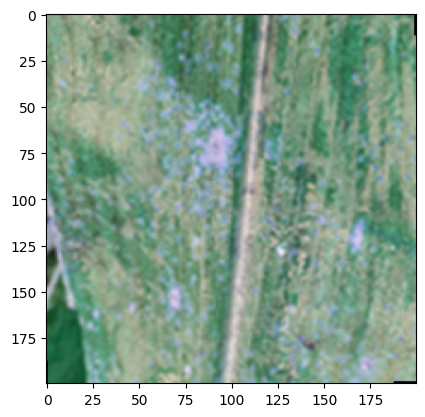

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/content/drive/MyDrive/titl_defence/Dataset/final_crop_image"

CATEGORIES = ["Common_rust", "gray_leaf_spot", "healthy"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

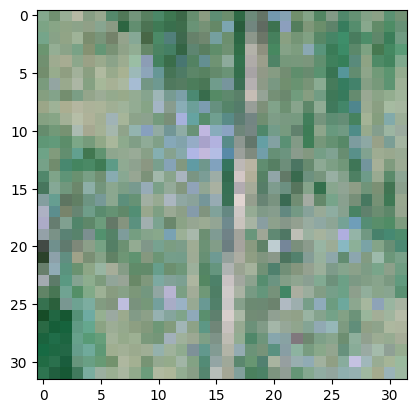

In [ ]:
IMG_SIZE = 32

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

100%|██████████| 3450/3450 [03:30<00:00, 16.37it/s]


In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X) / 255
X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [ ]:
num_classes = 43
input_shape = (32, 32, 3)

#x_train, y_train, x_test, y_test = train_test_split(X, y, test_size=0.2)
(x_train, x_test, y_train, y_test) = train_test_split(X, y,
    test_size=0.2)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (8520, 32, 32, 3) - y_train shape: (8520,)
x_test shape: (2130, 32, 32, 3) - y_test shape: (2130,)


In [ ]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

FNet model

In [ ]:
class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)

        self.ffn = keras.Sequential(
            [
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

In [ ]:
fnet_blocks = keras.Sequential(
    [FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.001
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history = run_experiment(fnet_classifier)

Epoch 1/100


59/60 [============================>.] - ETA: 0s - loss: 0.8681 - acc: 0.6332 - top5-acc: 0.9873

60/60 [==============================] - 15s 66ms/step - loss: 0.8634 - acc: 0.6347 - top5-acc: 0.9875 - val_loss: 0.5729 - val_acc: 0.7512 - val_top5-acc: 1.0000 - lr: 0.0010
Epoch 2/100
60/60 [==============================] - 4s 65ms/step - loss: 0.5403 - acc: 0.7753 - top5-acc: 1.0000 - val_loss: 0.4523 - val_acc: 0.8263 - val_top5-acc: 1.0000 - lr: 0.0010
Epoch 3/100
60/60 [==============================] - 4s 59ms/step - loss: 0.4087 - acc: 0.8284 - top5-acc: 1.0000 - val_loss: 0.3343 - val_acc: 0.8533 - val_top5-acc: 1.0000 - lr: 0.0010
Epoch 4/100
60/60 [==============================] - 3s 54ms/step - loss: 0.3290 - acc: 0.8675 - top5-acc: 1.0000 - val_loss: 0.2696 - val_acc: 0.8920 - val_top5-acc: 1.0000 - lr: 0.0010
Epoch 5/100
60/60 [==============================] - 3s 54ms/step - loss: 0.2301 - acc: 0.9075 - top5-acc: 1.0000 - val_loss: 0.1818 - val_acc: 0.9167 - val_top5-acc: 1.0000 - lr: 0.0010
Epoch 6/100
60/60 [==============================] - 3s 58ms/step - loss: 0.

gMLP model

In [ ]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

In [ ]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history = run_experiment(gmlp_classifier)

Epoch 1/100
60/60 [==============================] - 16s 88ms/step - loss: 0.7924 - acc: 0.7115 - top5-acc: 0.9842 - val_loss: 0.3820 - val_acc: 0.8439 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 2/100
60/60 [==============================] - 4s 72ms/step - loss: 0.3141 - acc: 0.8788 - top5-acc: 1.0000 - val_loss: 0.1956 - val_acc: 0.9284 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 3/100
60/60 [==============================] - 4s 73ms/step - loss: 0.1792 - acc: 0.9311 - top5-acc: 1.0000 - val_loss: 0.1185 - val_acc: 0.9577 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 4/100
60/60 [==============================] - 4s 66ms/step - loss: 0.1294 - acc: 0.9542 - top5-acc: 1.0000 - val_loss: 0.1004 - val_acc: 0.9624 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 5/100
60/60 [==============================] - 4s 68ms/step - loss: 0.1140 - acc: 0.9604 - top5-acc: 1.0000 - val_loss: 0.0826 - val_acc: 0.9742 - val_top5-acc: 1.0000 - lr: 0.0030
Epoch 6/100
60/60 [==============================] - 4s 70ms/ste